In [1]:
# Visualization of the activity in between 2 classes
# for FGNs
# ideally theire should be a large zone of no activity


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets as skdatasets
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle as shuffle_in_unison

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

crescent                Wed Aug  5 13:26:29 2020  418.87.01
[0] GeForce RTX 2080 Ti | 48'C,   0 % |    10 / 10989 MB |
[1] GeForce RTX 2080 Ti | 46'C,   0 % |    10 / 10989 MB |


In [6]:
# manualy set cuda device
torch.cuda.set_device(0)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
total_num_samples = 5000
num_classes = 2

# class 0
c1_center = [1,-1]
stretch_1 = 0.01*np.array([3, 1])
# rotate = -np.pi/4
c1_samples = c1_center + stretch_1*np.random.randn(total_num_samples,2)

# class 1
c2_center = [-1,1]
stretch_2 = 0.1*np.array([1, 20])
c2_samples = c2_center + stretch_2*np.random.randn(total_num_samples,2)


labels = np.concatenate(([0 for _ in c1_samples], [1 for _ in c2_samples]))
samples = np.concatenate((c1_samples, c2_samples))

samples, labels = shuffle_in_unison(samples, labels)

# # normalize
# scaler = StandardScaler()
# scaler.fit(samples)
# samples = scaler.transform(samples)

# train/test split
ratio=4.0/5.0
split_index = int(len(samples)*ratio)

train_samples, train_labels = samples[:split_index], labels[:split_index]
test_samples, test_labels = samples[split_index:], labels[split_index:]

num_samples = len(train_samples)

<IPython.core.display.Javascript object>


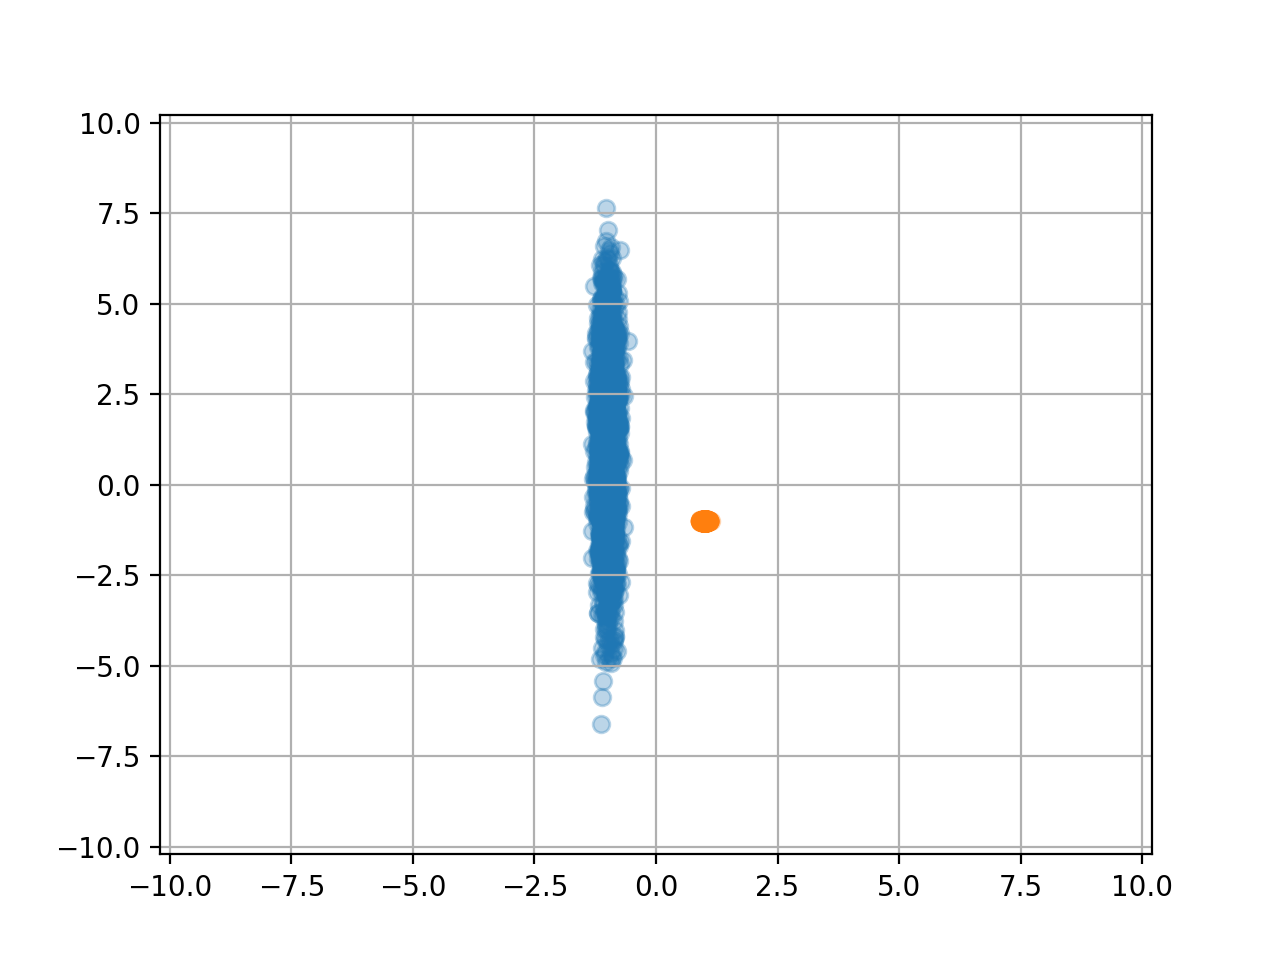

In [9]:
# 2D Check 
samples_x_1 = [x for x,l in zip(train_samples[:,0], train_labels) if l==0]
samples_y_1 = [y for y,l in zip(train_samples[:,1], train_labels) if l==0]

samples_x_2 = [x for x,l in zip(train_samples[:,0], train_labels) if l==1]
samples_y_2 = [y for y,l in zip(train_samples[:,1], train_labels) if l==1]

plt.scatter(samples_x_2, samples_y_2, alpha=0.3)
plt.scatter(samples_x_1, samples_y_1, alpha=0.3)

plt.grid(True)
plt.axis([-1.3*np.max(np.abs(samples)),1.3*np.max(np.abs(samples)), -1.3*np.max(np.abs(samples)),1.3*np.max(np.abs(samples))])

plt.show()

In [10]:
# convert data to pytorch format 
tensor_train_x = torch.Tensor(train_samples)
tensor_train_y = torch.Tensor(train_labels)

tensor_test_x = torch.Tensor(test_samples)
tensor_test_y = torch.Tensor(test_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_train_x, tensor_train_y) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_test_x,tensor_test_y) # create your dataset


batch_size = 5000
my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data, batch_size=batch_size, shuffle=True) # create your dataloader

In [11]:
### PART 2: fully FGN network

In [12]:
# generic params
hidden_layer_sizes = []
drop_p = 0

# fgn specific params
print("hidden layers:", hidden_layer_sizes)
# covariance type: sphere, diag or full
covar_type = 'diag'
print("covariance:", covar_type)
ordinal = float(2.0)
print("ordinal for norm:", ordinal)
non_lin = True
print("non linearity:", non_lin)
free_biases = True
print("free biases:", free_biases)

print("drop prob:", drop_p)


# Initialize the fgn network
fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, free_biases=free_biases)
fgn_model.to(device)

hidden layers: []
covariance: diag
ordinal for norm: 2.0
non linearity: True
free biases: True
drop prob: 0


Feedforward_FGN_net(
  (hidden_layers): ModuleList()
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [13]:
# define model params to optimize
fgn_optimizer = optim.Adam(filter(lambda p: p.requires_grad, fgn_model.parameters()), lr=0.01)
# fgn_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()))

<IPython.core.display.Javascript object>


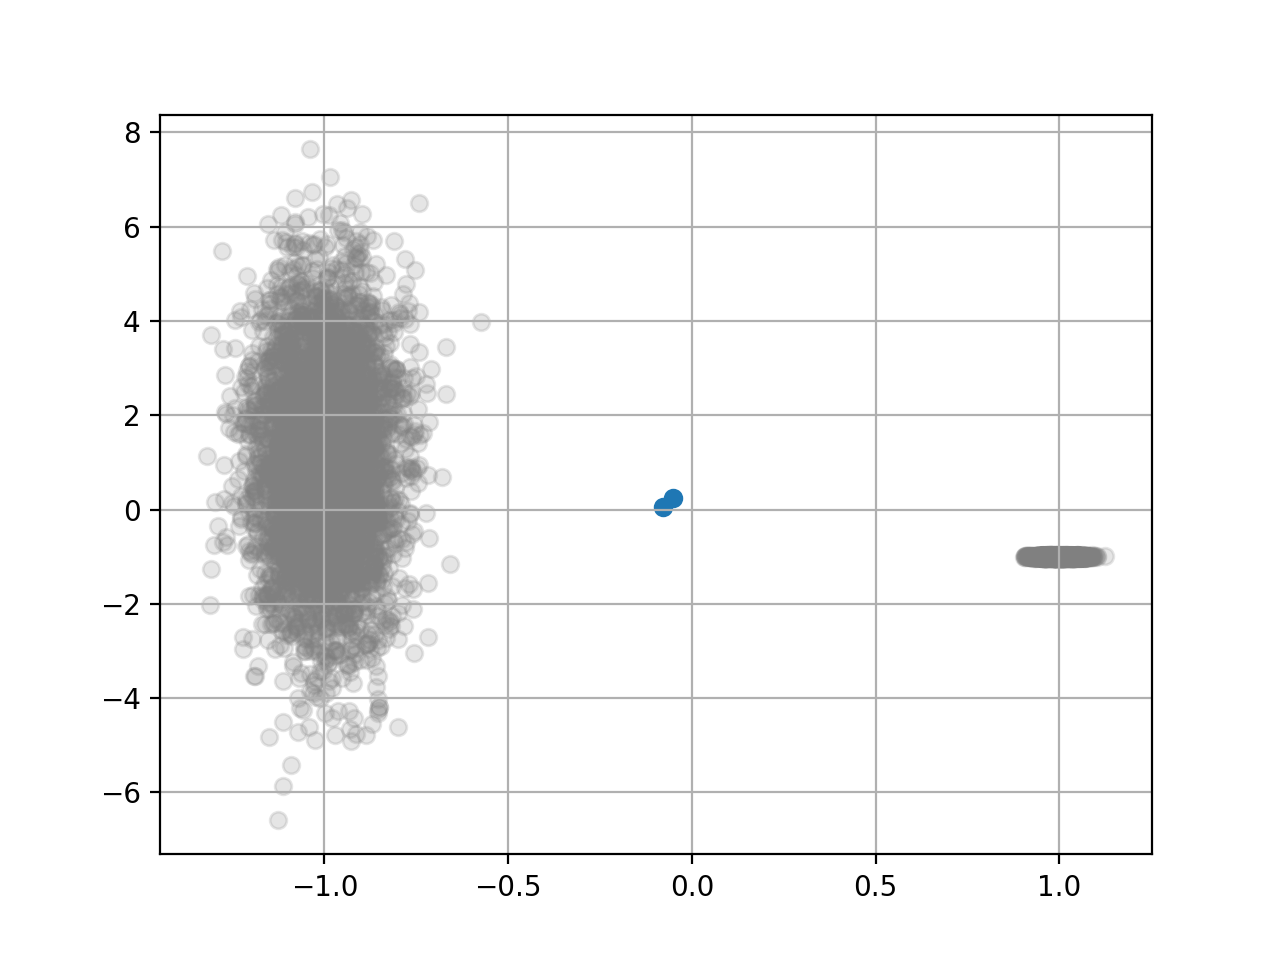

In [14]:
# plot centers of first layer
if len(hidden_layer_sizes)>0:
    x = list(zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy()))
else:
    x = list(zip(*fgn_model.state_dict()['fl.centers'].detach().cpu().numpy()))
plt.scatter(train_samples[:,0], train_samples[:,1], alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

In [15]:
# set centers of first layer
# fgn_model.set_first_layer_centers(my_dataloader)
fgn_model.fl.centers = torch.nn.Parameter(torch.tensor([[-1,1],[1,-1]],dtype=torch.float32, device=device))

<IPython.core.display.Javascript object>


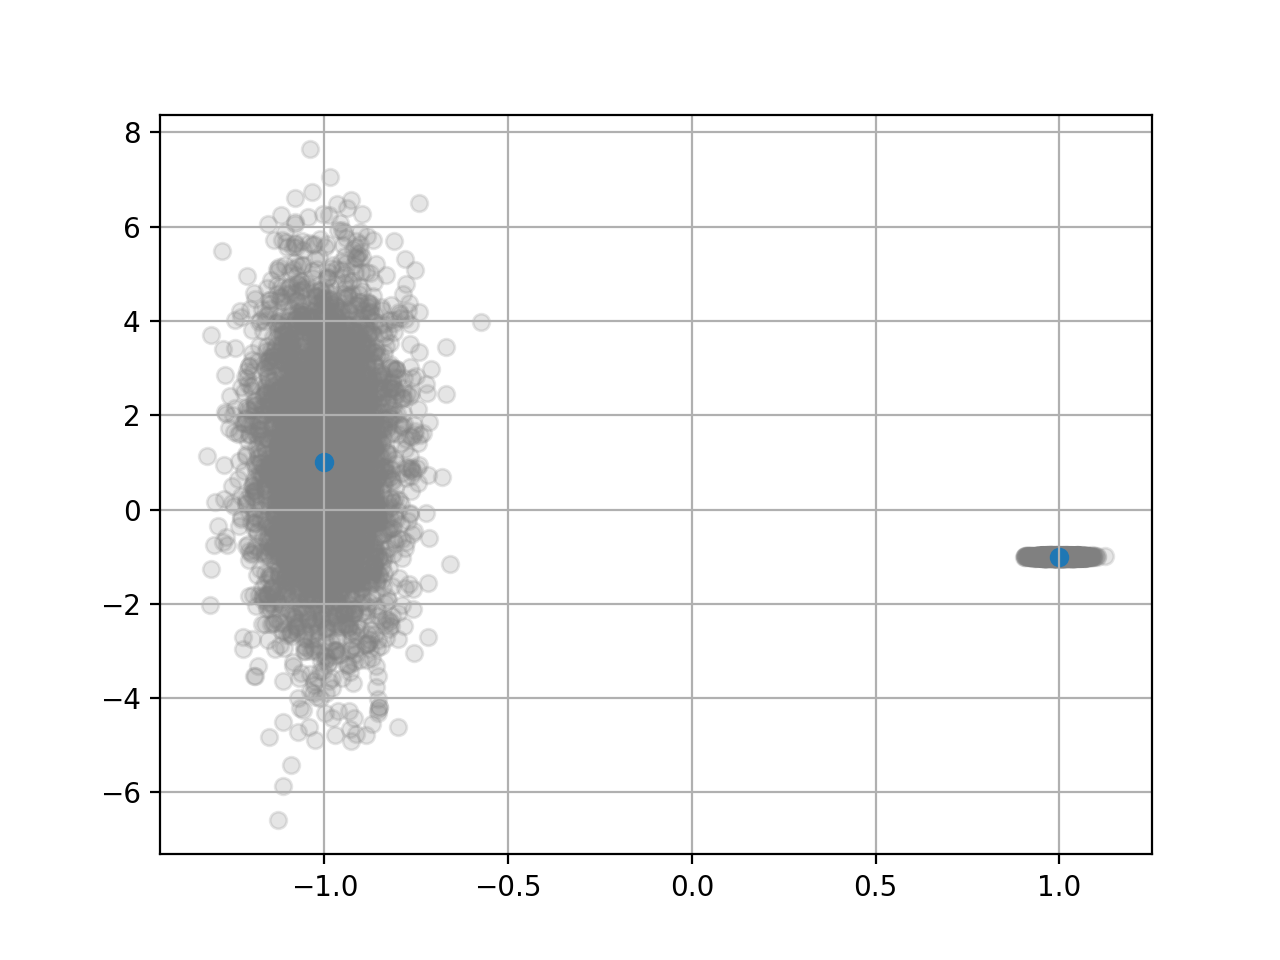

In [16]:
# plot centers of first layer
if len(hidden_layer_sizes)>0:
    x = list(zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy()))
else:
    x = list(zip(*fgn_model.state_dict()['fl.centers'].detach().cpu().numpy()))
plt.scatter(train_samples[:,0], train_samples[:,1], alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
plt.grid(True)
plt.show()

In [17]:
# model stats pre training
print(fgn_model)
print([p.size() for p in list(fgn_model.parameters())])
print([(n,p) for n,p in list(fgn_model.named_parameters()) if 'covar' in n ])
print("Training?", fgn_model.training) 
# print(fgn_model.state_dict())

print("losses")
print(fgnh.l2_loss(fgn_model))
print(fgnl.sigmas_loss(fgn_model))

Feedforward_FGN_net(
  (hidden_layers): ModuleList()
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)
[torch.Size([2]), torch.Size([2]), torch.Size([2, 2]), torch.Size([2]), torch.Size([2, 2]), torch.Size([2, 2])]
[('fl.inv_covars', Parameter containing:
tensor([[1.6000, 1.9849],
        [1.7750, 1.2061]], device='cuda:0', requires_grad=True))]
Training? True
losses
tensor([0.6755], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.4123], device='cuda:0', grad_fn=<DivBackward0>)


In [18]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = 1e-5
lmbda_sigs = 1e-1
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs loss", lmbda_sigs)

fgn_cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

lambda for l2 loss 1e-05
lambda for sigs loss 0.1


In [19]:
# train the network for N epochs
epochs = 75
fgn_train_res = fgnh.train(fgn_model, my_dataloader, 
                             fgn_cross_ent_loss, fgn_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 0.7421, Accuracy: 3479/8000 (43%)
Test set - Average loss: 0.7018, Accuracy: 1811/2000 (91%)
Epoch 1 Train set - Average loss: 0.7208, Accuracy: 3483/8000 (44%)
Test set - Average loss: 0.6863, Accuracy: 1828/2000 (91%)
Epoch 2 Train set - Average loss: 0.6996, Accuracy: 5296/8000 (66%)
Test set - Average loss: 0.6698, Accuracy: 1838/2000 (92%)
Epoch 3 Train set - Average loss: 0.6791, Accuracy: 7528/8000 (94%)
Test set - Average loss: 0.6537, Accuracy: 1848/2000 (92%)
Epoch 4 Train set - Average loss: 0.6600, Accuracy: 7532/8000 (94%)
Test set - Average loss: 0.6387, Accuracy: 1854/2000 (93%)
Epoch 5 Train set - Average loss: 0.6427, Accuracy: 7533/8000 (94%)
Test set - Average loss: 0.6251, Accuracy: 1862/2000 (93%)
Epoch 6 Train set - Average loss: 0.6269, Accuracy: 7528/8000 (94%)
Test set - Average loss: 0.6119, Accuracy: 1866/2000 (93%)
Epoch 7 Train set - Average loss: 0.6121, Accuracy: 7536/8000 (94%)
Test set - Average loss: 0.5986, Accuracy: 

Epoch 65 Train set - Average loss: 0.2177, Accuracy: 7999/8000 (100%)
Test set - Average loss: 0.2263, Accuracy: 2000/2000 (100%)
Epoch 66 Train set - Average loss: 0.2161, Accuracy: 7999/8000 (100%)
Test set - Average loss: 0.2246, Accuracy: 2000/2000 (100%)
Epoch 67 Train set - Average loss: 0.2146, Accuracy: 7999/8000 (100%)
Test set - Average loss: 0.2230, Accuracy: 2000/2000 (100%)
Epoch 68 Train set - Average loss: 0.2129, Accuracy: 7999/8000 (100%)
Test set - Average loss: 0.2214, Accuracy: 2000/2000 (100%)
Epoch 69 Train set - Average loss: 0.2113, Accuracy: 7999/8000 (100%)
Test set - Average loss: 0.2199, Accuracy: 2000/2000 (100%)
Epoch 70 Train set - Average loss: 0.2099, Accuracy: 7999/8000 (100%)
Test set - Average loss: 0.2184, Accuracy: 2000/2000 (100%)
Epoch 71 Train set - Average loss: 0.2083, Accuracy: 7999/8000 (100%)
Test set - Average loss: 0.2169, Accuracy: 2000/2000 (100%)
Epoch 72 Train set - Average loss: 0.2072, Accuracy: 7999/8000 (100%)
Test set - Average l

In [20]:
# model stats post training
print(fgn_model)
print([p.size() for p in list(fgn_model.parameters())])
print([(n,p) for n,p in list(fgn_model.named_parameters()) if 'covar' in n ])
print("Training?", fgn_model.training) 

print("losses")
print(fgnh.l2_loss(fgn_model))
print(fgnl.sigmas_loss(fgn_model))

Feedforward_FGN_net(
  (hidden_layers): ModuleList()
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)
[torch.Size([2]), torch.Size([2]), torch.Size([2, 2]), torch.Size([2]), torch.Size([2, 2]), torch.Size([2, 2])]
[('fl.inv_covars', Parameter containing:
tensor([[2.1717, 0.6649],
        [2.5233, 2.1167]], device='cuda:0', requires_grad=True))]
Training? False
losses
tensor([2.1007], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.7136], device='cuda:0', grad_fn=<DivBackward0>)


In [21]:
fgn_model.state_dict()

OrderedDict([('ib.weight', tensor([1.0305, 1.0607], device='cuda:0')),
             ('ib.bias', tensor([-0.0084, -0.3532], device='cuda:0')),
             ('ib.running_mean', tensor([ 0.0111, -0.0047], device='cuda:0')),
             ('ib.running_var', tensor([1.0058, 2.9719], device='cuda:0')),
             ('ib.num_batches_tracked', tensor(150, device='cuda:0')),
             ('fl.weights',
              tensor([[ 1.7177, -0.7832],
                      [-0.4670,  1.5601]], device='cuda:0')),
             ('fl.biases', tensor([-1.4777, -0.9169], device='cuda:0')),
             ('fl.centers',
              tensor([[-1.,  1.],
                      [ 1., -1.]], device='cuda:0')),
             ('fl.inv_covars',
              tensor([[2.1717, 0.6649],
                      [2.5233, 2.1167]], device='cuda:0'))])

In [22]:
# test the statibility of the model (these numbers should be close as final lines above, depending)

_ = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)


Test set - Average loss: 0.2031, Accuracy: 8000/8000 (100%)
Test set - Average loss: 0.2127, Accuracy: 2000/2000 (100%)


<IPython.core.display.Javascript object>


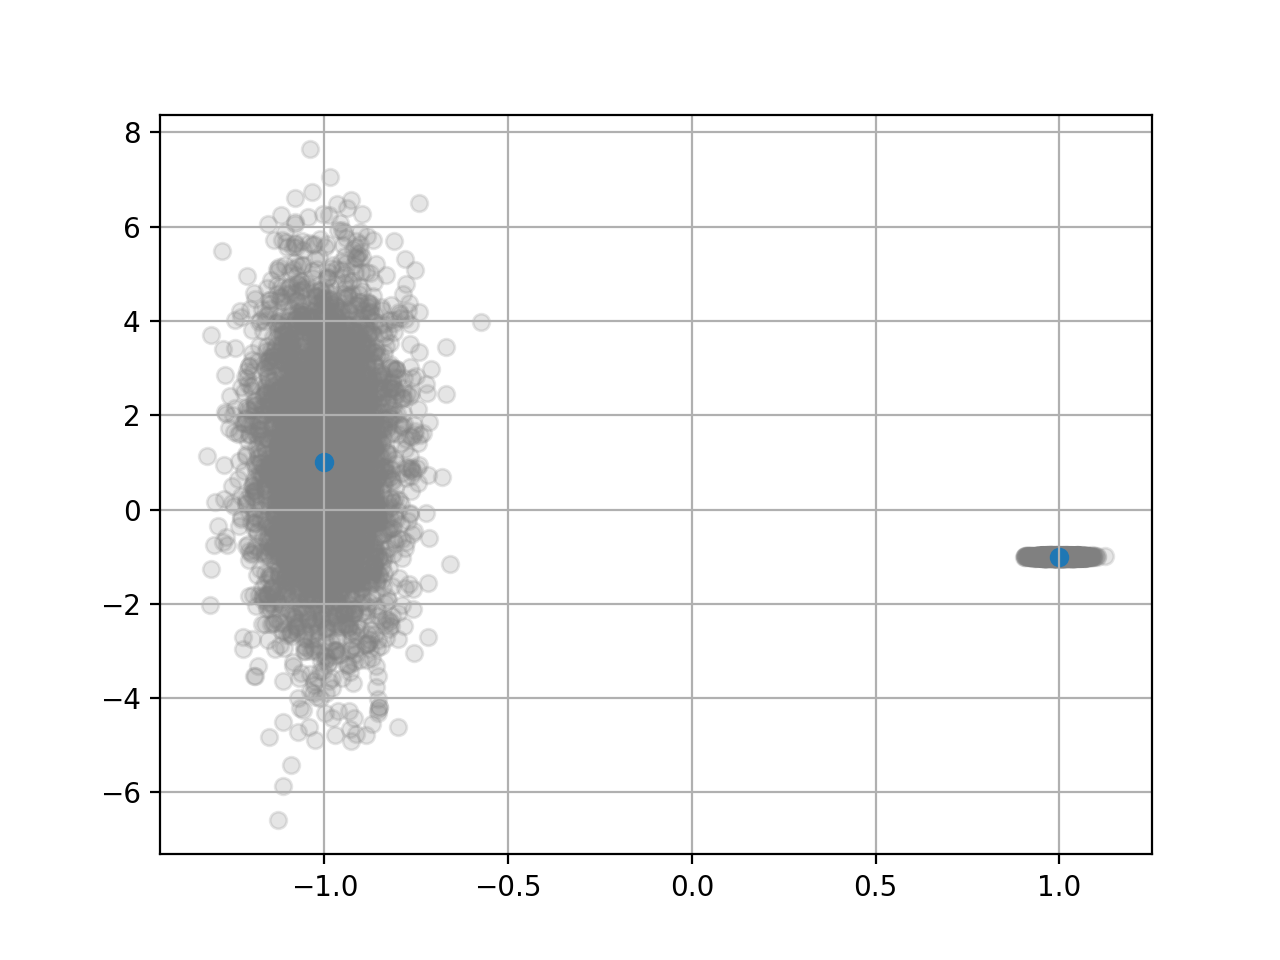

In [23]:
# plot centers of first layer
if len(hidden_layer_sizes)>0:
    x = list(zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy()))
else:
    x = list(zip(*fgn_model.state_dict()['fl.centers'].detach().cpu().numpy()))
plt.scatter(train_samples[:,0], train_samples[:,1], alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


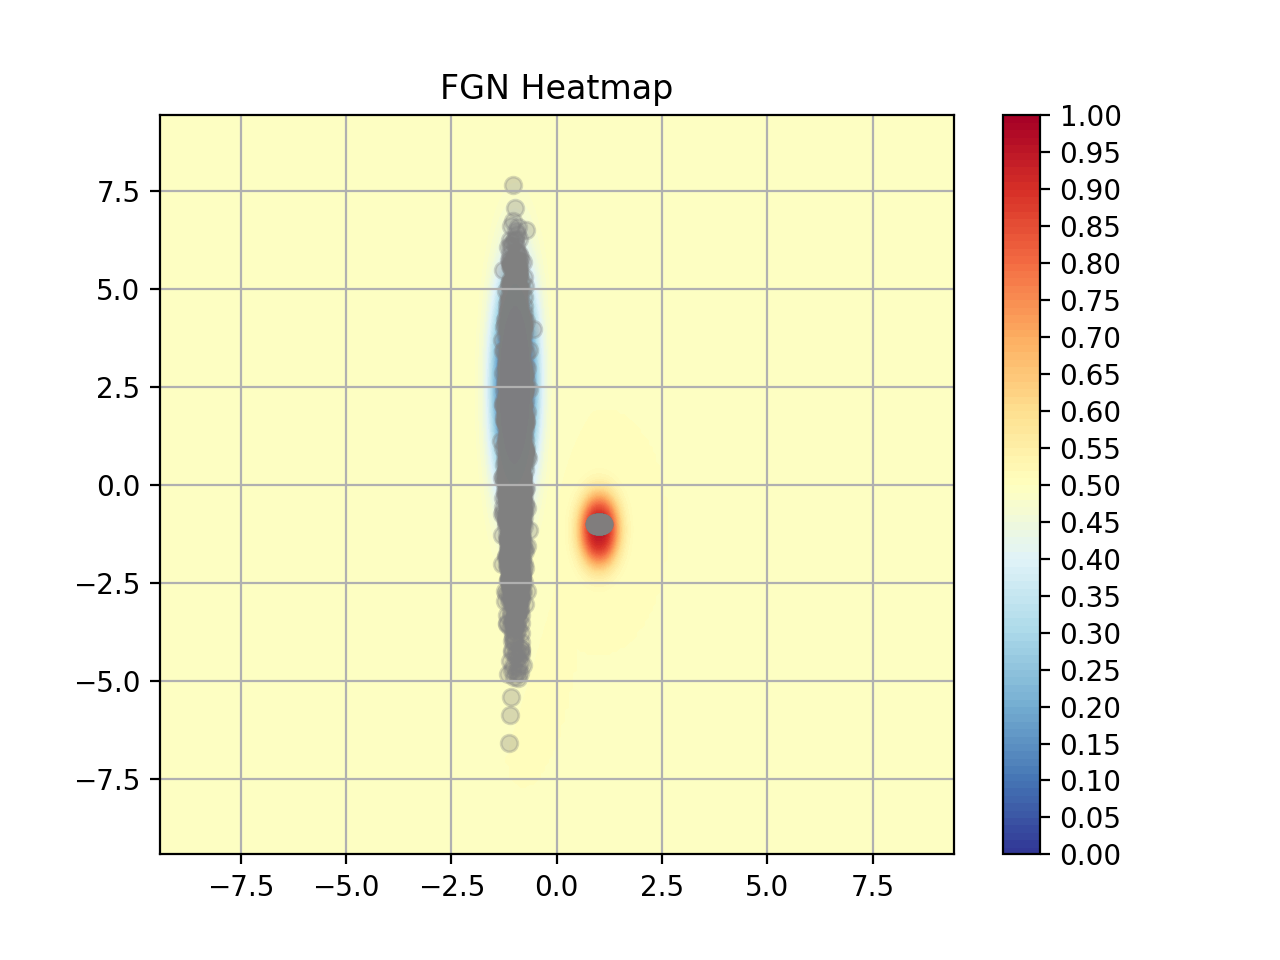

<IPython.core.display.Javascript object>


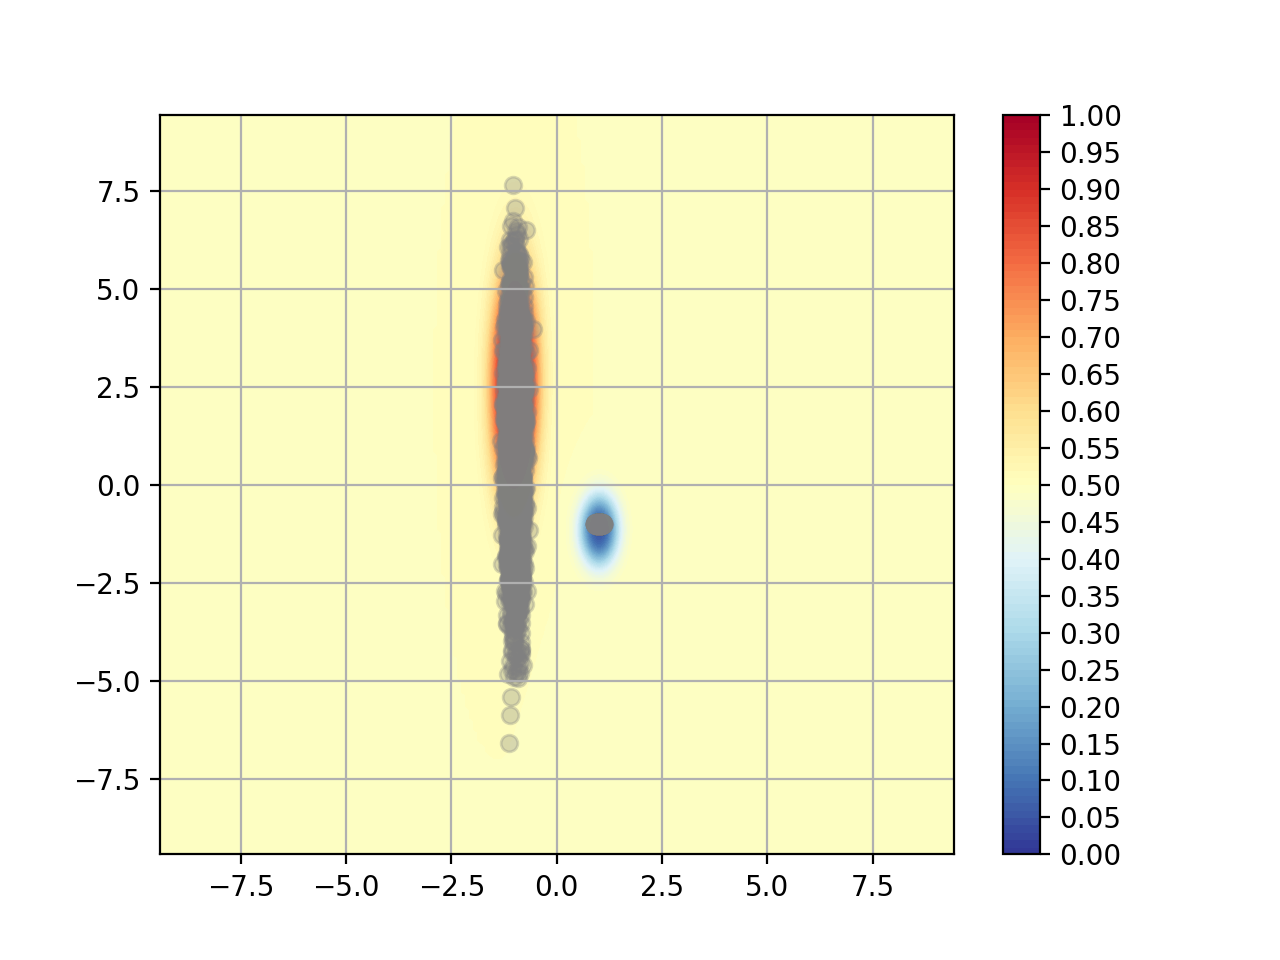

In [24]:
scale_max = np.max(np.abs(samples))

fgnh.plot_2D_heatmap(fgn_model, plot_mode='full', title="FGN Heatmap", scale=1.2*scale_max, show_data=my_dataloader)

<IPython.core.display.Javascript object>


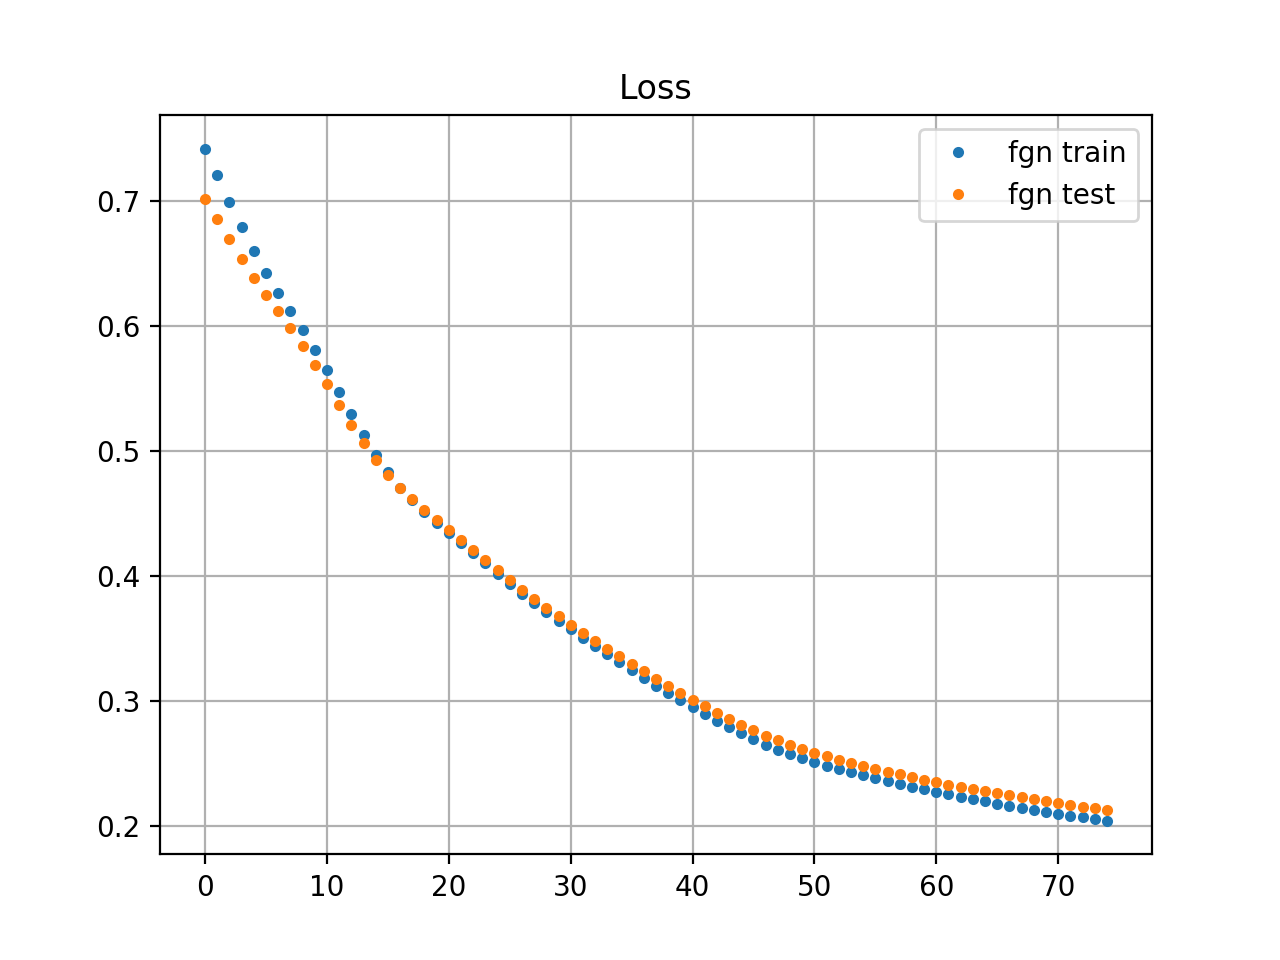

<IPython.core.display.Javascript object>


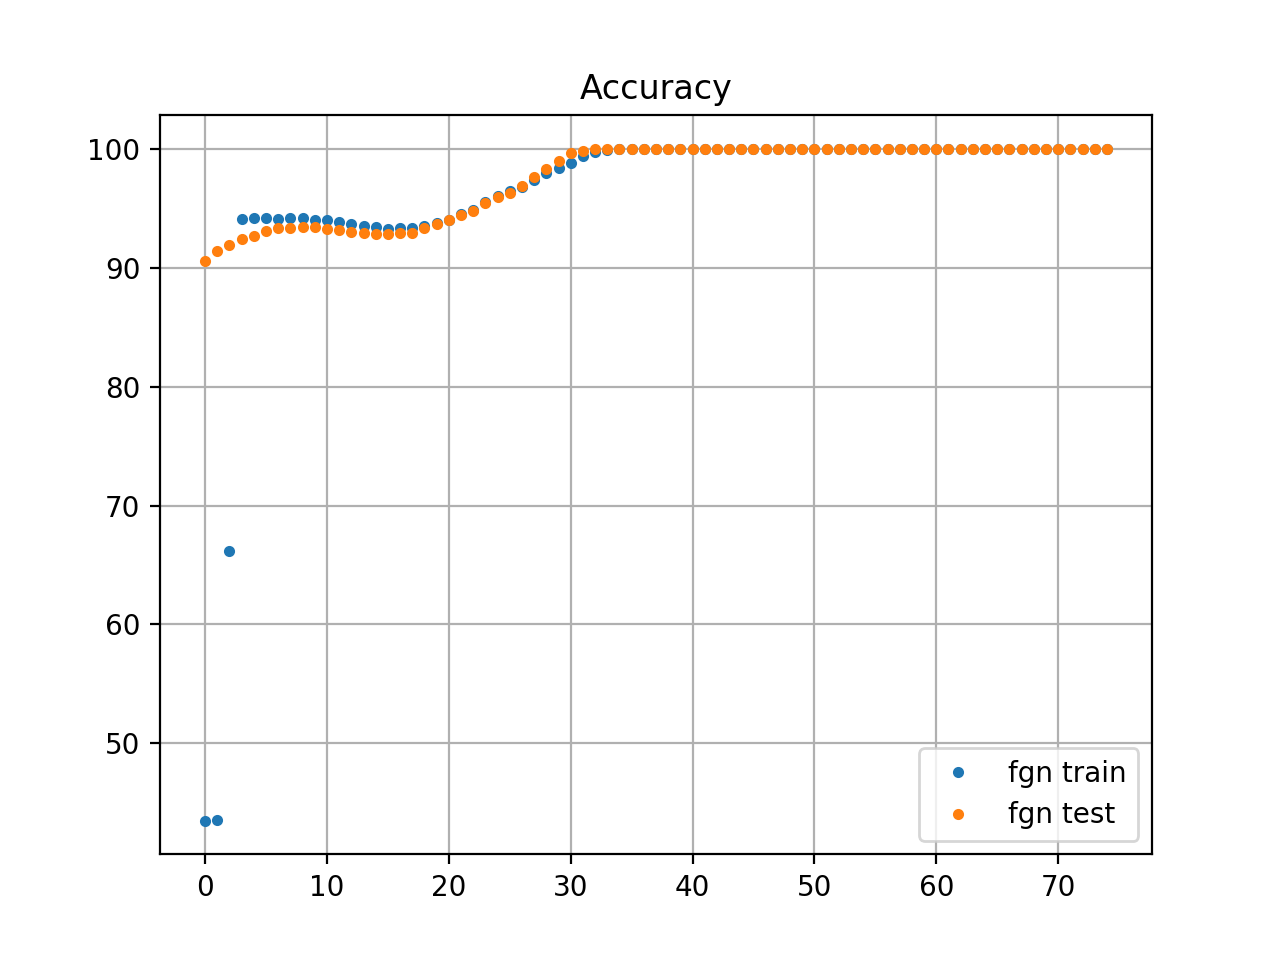

In [25]:
# acc and loss hist
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [26]:
### plot some FGN param movement during training

<IPython.core.display.Javascript object>


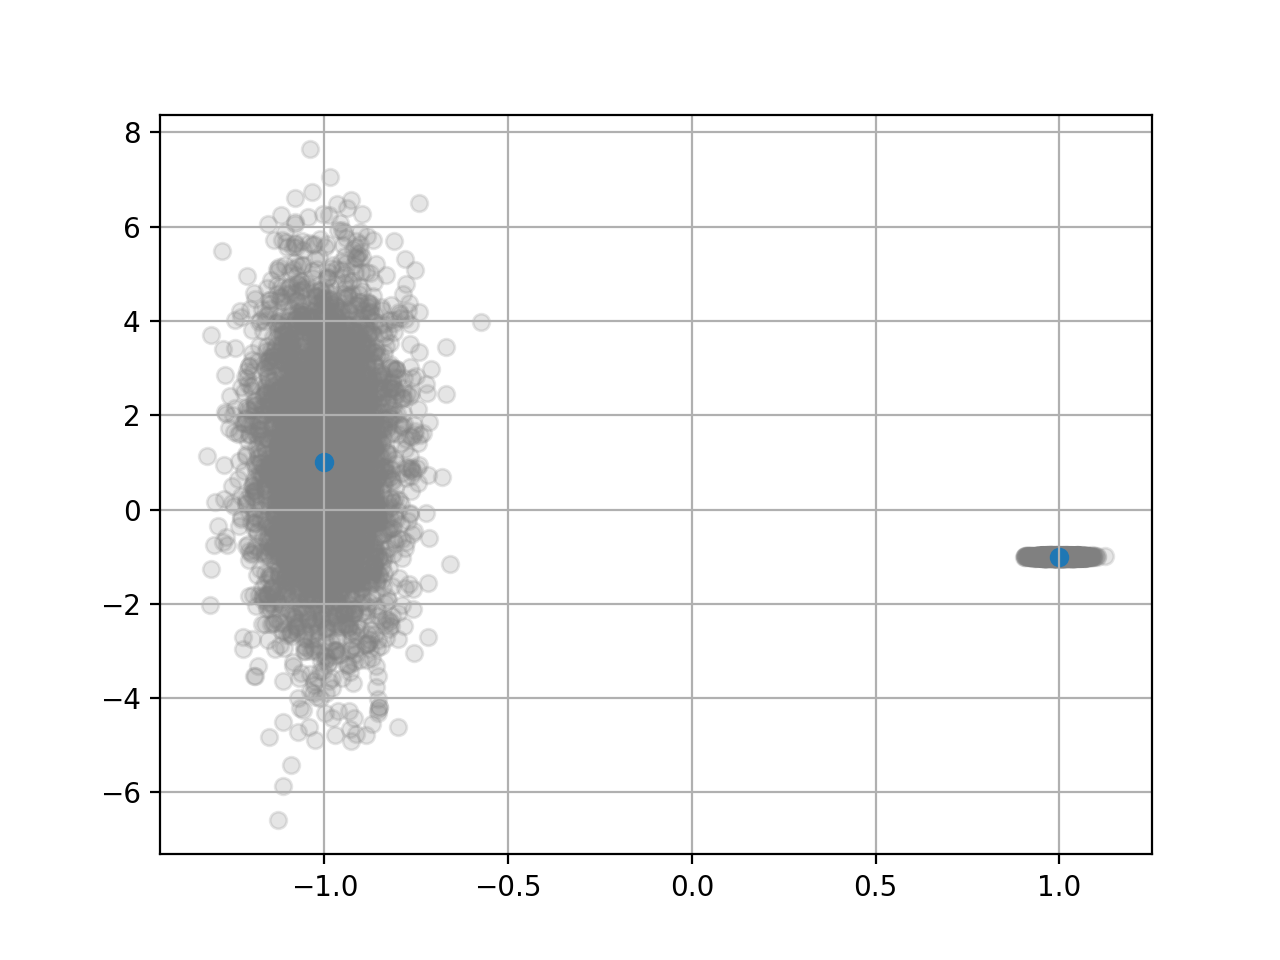

In [27]:
# plot centers of first layer
if len(hidden_layer_sizes)>0:
    x = list(zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy()))
else:
    x = list(zip(*fgn_model.state_dict()['fl.centers'].detach().cpu().numpy()))
plt.scatter(train_samples[:,0], train_samples[:,1], alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
# plt.axis([-8,10, -8,10])
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


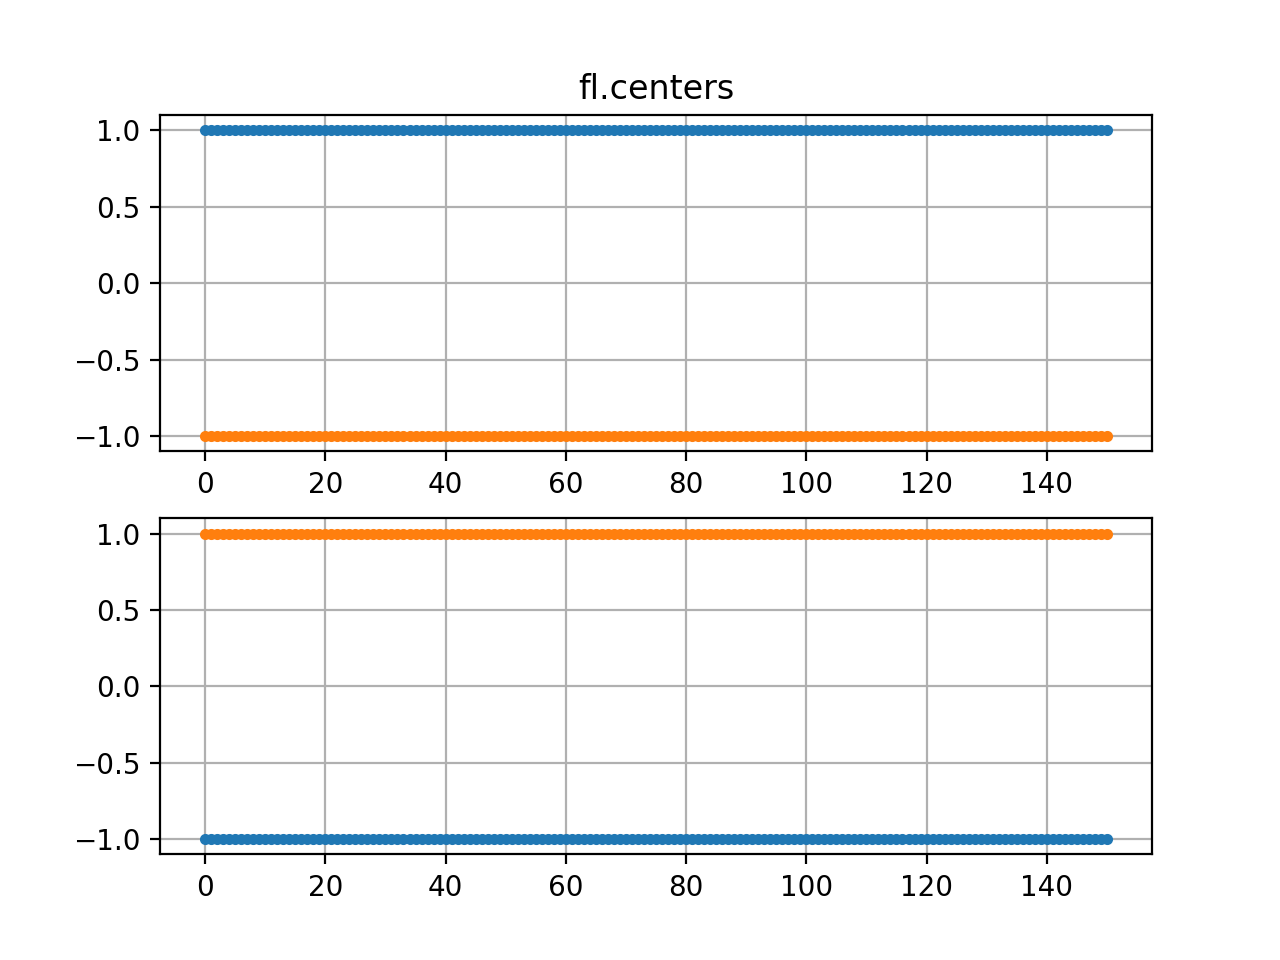

In [28]:
# plot centers history for only some hidden layer neuron
fgnl.plot_centers_histories(fgn_train_res['histories'])

<IPython.core.display.Javascript object>


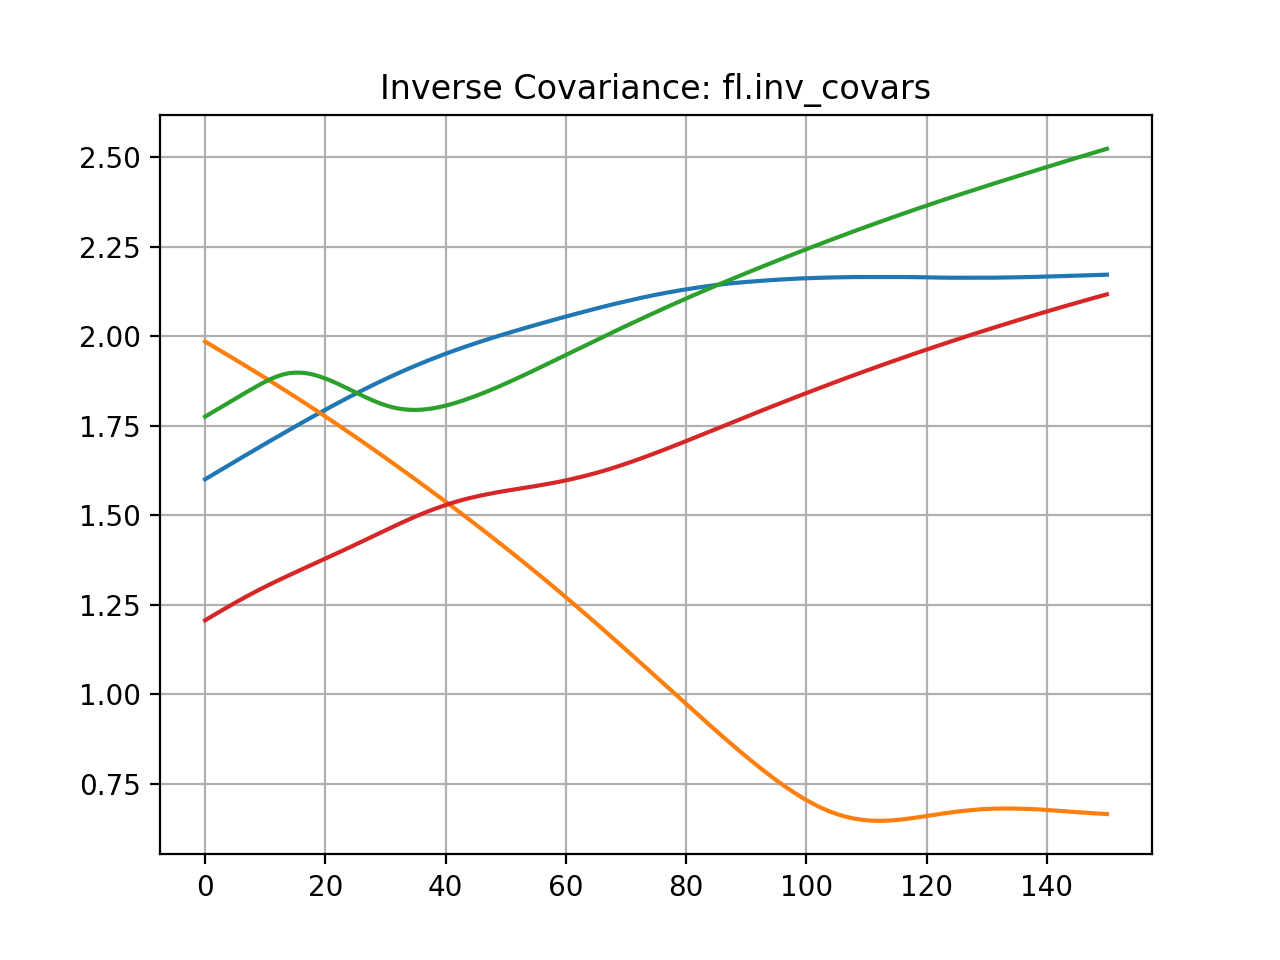

<IPython.core.display.Javascript object>


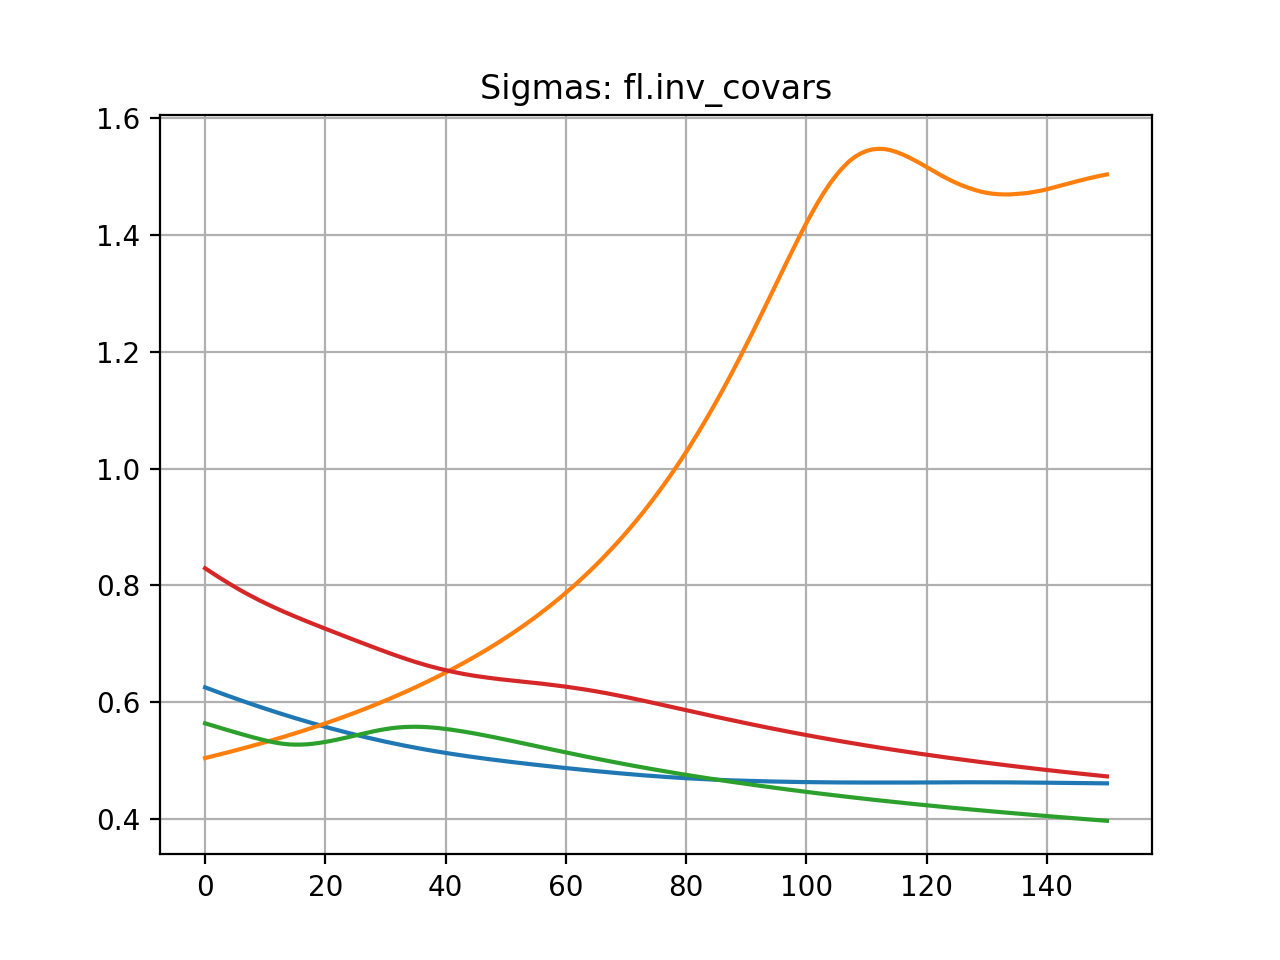

In [29]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
fgnl.plot_sigmas_histories(fgn_train_res['histories'], covar_type=fgn_model.covar_type)

In [30]:
# Initialize the fgn network
fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=2, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, free_biases=free_biases)


In [47]:
### manually set params
fgn_model.eval()

fgn_model.fl.weights = torch.nn.Parameter(torch.tensor([[ 1, -1],[-1,  1]],dtype=torch.float32))
fgn_model.fl.biases = torch.nn.Parameter(torch.tensor([0,0],dtype=torch.float32))
fgn_model.fl.centers = torch.nn.Parameter(torch.tensor([[-1,1],[1,-1]],dtype=torch.float32))
fgn_model.fl.inv_covars = torch.nn.Parameter(torch.tensor([[2.1717, 0.6649],[2.5233, 2.1167]],dtype=torch.float32))

fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList()
  (ib): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [48]:
print(fgn_model.state_dict())

OrderedDict([('ib.weight', tensor([1., 1.], device='cuda:0')), ('ib.bias', tensor([0., 0.], device='cuda:0')), ('ib.running_mean', tensor([0., 0.], device='cuda:0')), ('ib.running_var', tensor([1., 1.], device='cuda:0')), ('ib.num_batches_tracked', tensor(0, device='cuda:0')), ('fl.weights', tensor([[ 1., -1.],
        [-1.,  1.]], device='cuda:0')), ('fl.biases', tensor([0., 0.], device='cuda:0')), ('fl.centers', tensor([[-1.,  1.],
        [ 1., -1.]], device='cuda:0')), ('fl.inv_covars', tensor([[2.1717, 0.6649],
        [2.5233, 2.1167]], device='cuda:0'))])


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


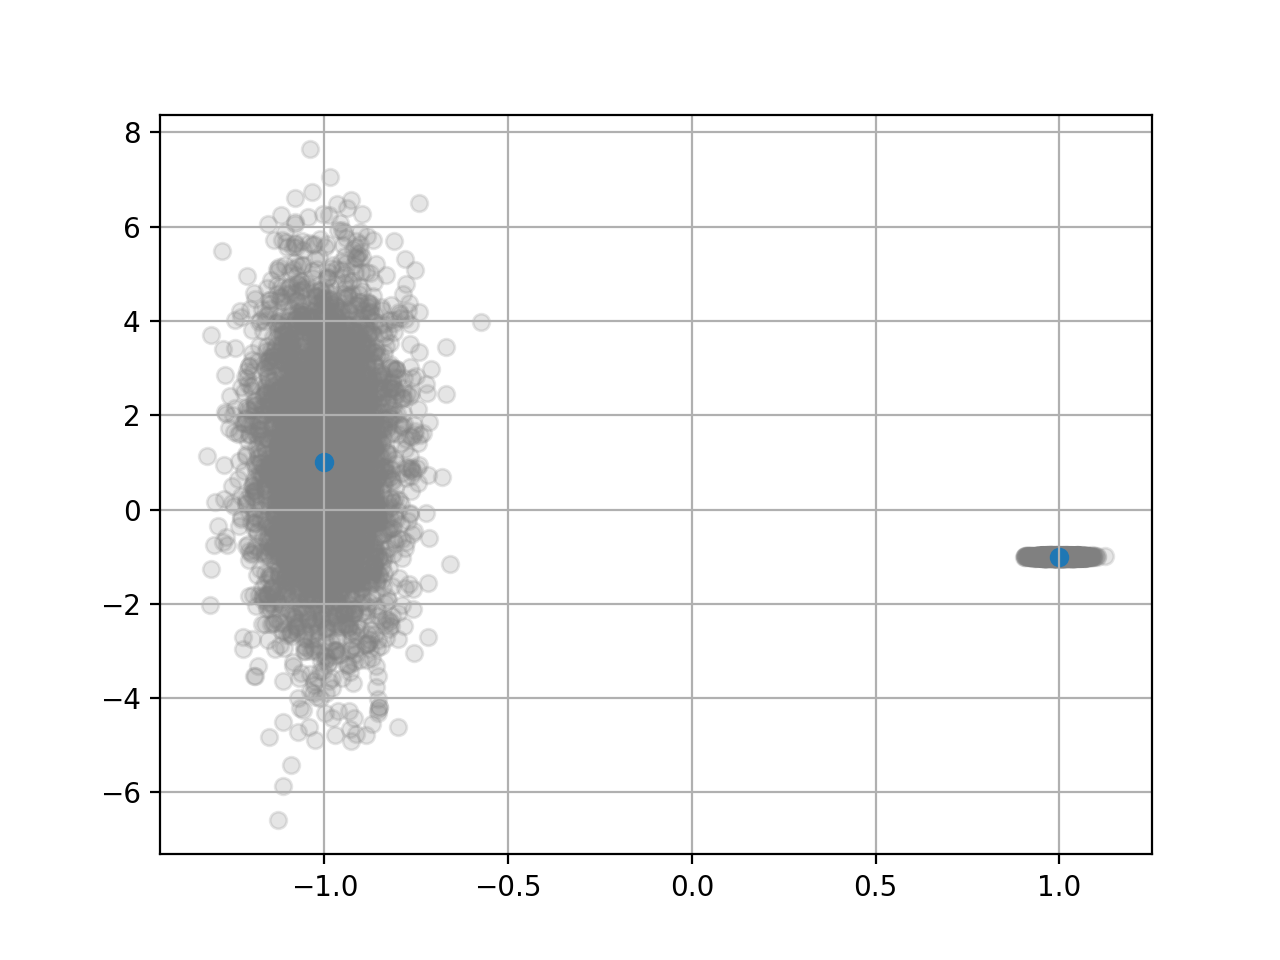

In [49]:
# plot centers of first layer
if len(hidden_layer_sizes)>0:
    x = list(zip(*fgn_model.state_dict()['hidden_layers.1.centers'].detach().cpu().numpy()))
else:
    x = list(zip(*fgn_model.state_dict()['fl.centers'].detach().cpu().numpy()))
plt.scatter(train_samples[:,0], train_samples[:,1], alpha=0.2, c='gray')
plt.scatter(x[0], x[1])
plt.grid(True)
plt.show()

In [50]:
# accuracy
_ = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

_ = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.3379, Accuracy: 7365/8000 (92%)
Test set - Average loss: 0.3485, Accuracy: 1828/2000 (91%)


<IPython.core.display.Javascript object>


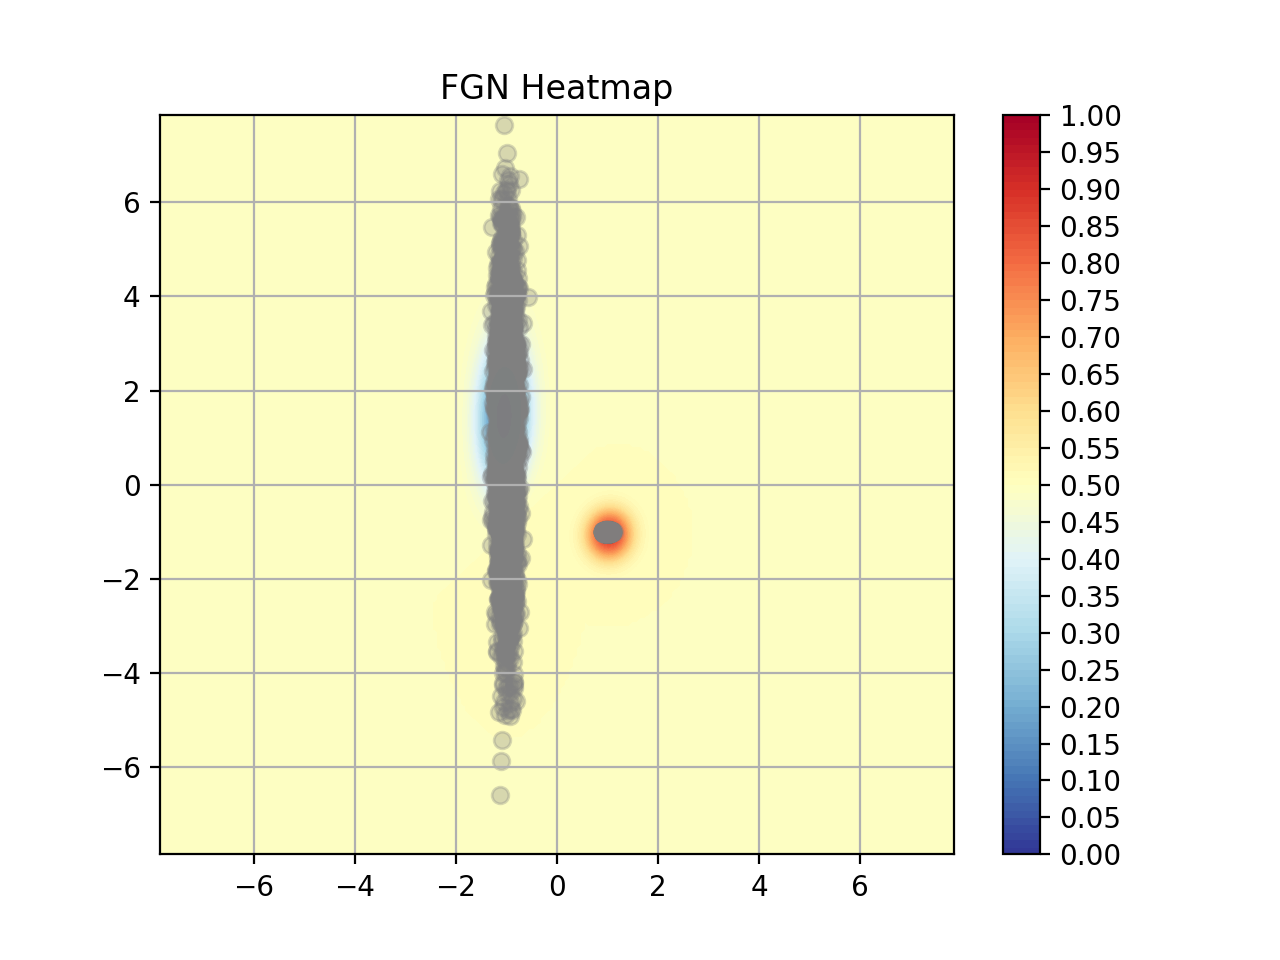

<IPython.core.display.Javascript object>


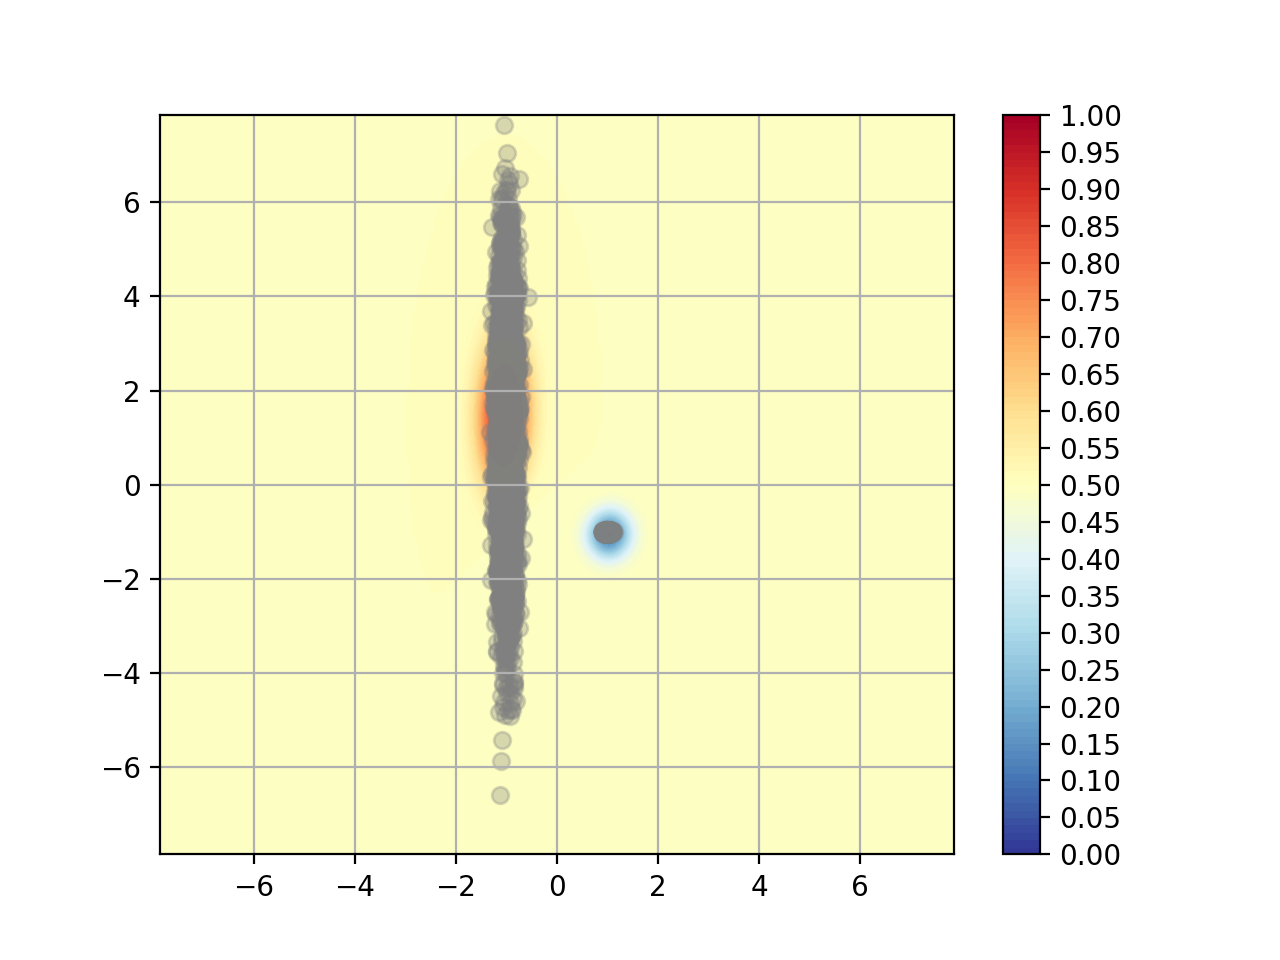

In [51]:
scale_max = np.max(np.abs(samples))

fgnh.plot_2D_heatmap(fgn_model, plot_mode='full', title="FGN Heatmap", scale=scale_max, show_data=my_dataloader)

In [52]:
print("losses")
print(fgnh.l2_loss(fgn_model))
print(fgnl.sigmas_loss(fgn_model))

losses
tensor([1.5000], device='cuda:0', grad_fn=<DivBackward0>)
tensor([0.7136], device='cuda:0', grad_fn=<DivBackward0>)
